# Along-contour plots of eddy transport and energy conversions

for sigma_1 >=1032.53

or for 1032.53 <=sigma_1<=1032.55 (top of bottom layer, doesn't touch bottom)

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46495/status,
Dashboard: /proxy/46495/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45295,Workers: 4
Dashboard: /proxy/46495/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43127,Total threads: 2
Dashboard: /proxy/44757/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42947,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
import sys  
sys.path.insert(0, '/g/data/x77/cy8964/Honours/spatial_correspodence/')

from correlation1 import Compute_Correlation


### Load important parameters

In [5]:
expt = '01deg_jra55v13_ryf9091'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [6]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

In [7]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 2.27 s, sys: 916 ms, total: 3.18 s
Wall time: 17.6 s


In [8]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
MKE = xr.open_dataset(save_dir+'MKE_10yr.nc').MKE
EKE = xr.open_dataset(save_dir+'EKE_10yr.nc').EKE
Reynolds = xr.open_dataset(save_dir+'Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset(save_dir+'Form_stress_10yr_updatedMP.nc').Form_stress
h_bar = xr.open_dataset(save_dir+'h_bar_10yr.nc').h_bar

In [9]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 13})


In [10]:
j_contour = 'L'
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour


# run above distance indices code
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


slice(1032.53, 1032.6, None)
8.590545590319502
76.85367140381616 118.63260167414822


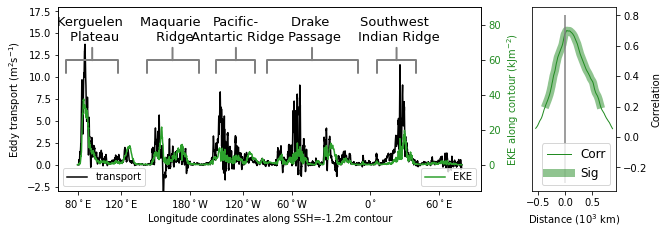

In [13]:
N=10
j_contour ='L'
rhoslice = slice(1032.53,1032.6)
if contour_dict[j_contour]['shifted']==True:
    suffix = '_shiftedback'
else:
    suffix = ''
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
#top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
#bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
#vh_eddy_masked= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
# mask out water that touches surface or bottom on average
SSH = contour_dict[j_contour]['SSH']
# if SSH > -0.45:
#     print('SSH too big!!')
# rhoslice = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])
print(str(rhoslice))
eddy_notcumsum = (vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')
segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length.values
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').EKE_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').values/segment_length.values
z_scaled = y/np.max(y)
EKE_scaled = EKE/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
print(max(t))
print(min(N),max(N))
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)
distance = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
distance_small = distance[0:len(corr)]
distance_combined = np.append(-np.flip(distance_small)[:-1],distance_small)

f, (ax, ax_inset) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize = (10,3.5))
ax.plot(distance,y, color = 'k', label = 'transport')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('EKE along contour (kJm$^{-2}$)', color='forestgreen')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='forestgreen')
ax2.plot(distance,EKE/1e3, color = 'C2', label = 'EKE')

ax_inset.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'forestgreen',linewidth=1,label='Corr')
ax_inset.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='forestgreen',linewidth=8,alpha=0.5,label="Sig")
ax_inset.vlines(0,-0.3,0.8, color = 'grey')
ax.legend(loc = 'lower left')
ax2.legend(loc = 'lower right')
ax.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
ax.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
ax.set_xlabel('Longitude coordinates along SSH=-1.2m contour')

ax_inset.legend(loc = 'lower right', fontsize = 12)
#ax.set_xlabel('Distance along SSH=-1.2m contour (10$^3$km), starting at 80$^\circ$E')
ax_inset.set_xlabel('Distance (10$^3$ km)')
ax.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_inset.yaxis.tick_right()
ax_inset.yaxis.set_label_position("right")
ax_inset.set_ylabel('Correlation')
#ax.set_title('contour SSH=-1.2m, $\sigma_1$=(1032,1032.5)')
#plt.subplots_adjust(wspace = 0)
ax.annotate('Kerguelen \n Plateau', xy=(0.08, 0.70), xytext=(0.08, 0.8), xycoords='axes fraction', 
            fontsize=13, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Maquarie \n Ridge', xy=(0.27, 0.70), xytext=(0.27, 0.8), xycoords='axes fraction', 
            fontsize=13, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Pacific-\n Antartic Ridge', xy=(0.42, 0.70), xytext=(0.42, 0.8), xycoords='axes fraction', 
            fontsize=13, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Drake \n Passage', xy=(0.6, 0.70), xytext=(0.6, 0.8), xycoords='axes fraction', 
            fontsize=13, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=1', lw=2.0, color = 'grey'))
ax.annotate('Southwest \n Indian Ridge', xy=(0.8, 0.70), xytext=(0.8, 0.8), xycoords='axes fraction', 
            fontsize=13, ha='center', va='bottom',
            #bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=1', lw=2.0, color = 'grey'))
ax2.set_ylim(-15,90)
ax.set_ylim(-3,18)

plt.subplots_adjust(wspace = 0.2,bottom = 0.15)

#f.savefig('EKEcontour.png',dpi = 400)

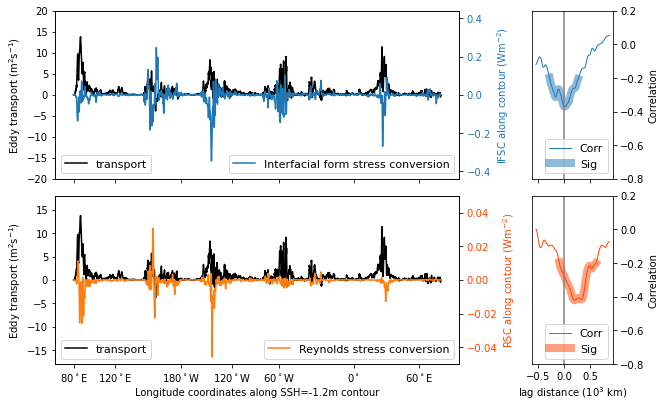

In [15]:
j_contour = 'L'
N=10
if contour_dict[j_contour]['shifted']==True:
    suffix = '_shiftedback'
else:
    suffix = ''
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
#top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
#bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
#vh_eddy_masked= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
# mask out water that touches surface or bottom on average
SSH = contour_dict[j_contour]['SSH']
# if SSH > -0.45:
#     print('SSH too big!!')
# rhoslice = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])

rhoslice = slice(1032.53,1032.6)

eddy_notcumsum = (vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins').fillna(0)
segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'_10yr_updatedMP.nc').Form_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)
distance = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
distance_small = distance[0:len(corr)]
distance_combined = np.append(-np.flip(distance_small)[:-1],distance_small)

f, ((ax, ax_inset), (axR,ax_insetR)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize = (10,6.5), sharex = 'col')
ax.plot(distance,y, color = 'k', label = 'transport')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('IFSC along contour (Wm$^{-2}$)', color='C0')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='C0')
ax2.plot(distance,EKE, color = 'C0', label = 'Interfacial form stress conversion')

ax_inset.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'C0',linewidth=1,label='Corr')
ax_inset.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='C0',linewidth=8,alpha=0.5,label="Sig")
ax_inset.vlines(0,-0.8,0.2, color = 'grey')
ax.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)

ax_inset.legend(loc = 'lower right', fontsize = 11)
ax.set_xlabel('')
ax_inset.set_xlabel('')
ax.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_inset.yaxis.tick_right()
ax_inset.yaxis.set_label_position("right")
ax_inset.set_ylabel('Correlation')

# ax_inset2 = plt.axes([0.17,0.77,0.2,0.1])
# ax_inset_otherside = ax_inset2.twinx()
# ax_inset_otherside.tick_params(axis='y', labelcolor='C0')
# ax_inset_otherside.plot(distance[4800:5000],EKE[4800:5000], color = 'C0')
# ax_inset2.plot(distance[4800:5000],y[4800:5000], color = 'k')
# ax_inset2.set_xlabel('distance (10$^3$ km)', fontsize = 10)
# ax_inset2.tick_params(axis='x', labelsize= 10)
# ax_inset2.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.tick_params(axis='y', labelsize= 10)

# ax_inset_otherside.set_ylim(-0.1,0.4)
# ax_inset2.set_ylim(-4,16)

ax2.set_ylim(-0.44,0.44)
ax.set_ylim(-20,20)
#same for Reynolds
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
N=10
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)

axR.plot(distance,y, color = 'k', label = 'transport')
ax2 = axR.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('RSC along contour (Wm$^{-2}$)', color='orangered')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='orangered')
ax2.plot(distance,EKE, color = 'C1', label = 'Reynolds stress conversion')

ax_insetR.plot(distance_combined[1550:1800],corr_combined_E[1550:1800],'orangered',linewidth=1,label='Corr')
ax_insetR.plot(distance_combined[1550:1800],(corr_combined_E*sig_combined_E)[1550:1800], color='orangered',linewidth=8,alpha=0.5,label="Sig")
ax_insetR.vlines(0,-0.8,0.2, color = 'grey')
axR.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)

ax_insetR.legend(loc = 'lower right', fontsize = 11)
ax_insetR.set_xlabel('lag distance (10$^3$ km)')
axR.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_insetR.yaxis.tick_right()
ax_insetR.yaxis.set_label_position("right")
ax_insetR.set_ylabel('Correlation')
ax_insetR.set_ylim(-0.8,0.2)
ax_inset.set_ylim(-0.8,0.2)


# ax_inset2 = plt.axes([0.3,0.405,0.2,0.075])
# ax_inset_otherside = ax_inset2.twinx()
# ax_inset_otherside.tick_params(axis='y', labelcolor='orangered')
# ax_inset_otherside.plot(distance[4800:5000],EKE[4800:5000], color = 'C1')
# ax_inset2.plot(distance[4800:5000],y[4800:5000], color = 'k')
# ax_inset2.set_xlabel('distance (10$^3$ km)', fontsize = 10)
# ax_inset2.tick_params(axis='x', labelsize= 10)
# ax_inset2.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.set_ylim(-0.025,0.05)
# ax_inset2.set_ylim(-8,16)

ax2.set_ylim(-0.05,0.05)
axR.set_ylim(-18,18)

save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour


# run above distance indices code
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

ax.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
ax.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
axR.set_xlabel('Longitude coordinates along SSH=-1.2m contour')


plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
plt.show()
f.subplots_adjust(bottom =0.15)

#ax_inset.set_xlim(-0.5,0.5)
#ax_insetR.set_xlim(-0.5,0.5)


#f.savefig('FSRScorr_SSH1.2.png',dpi = 400)

- transport in bottom layer correlated with both barotrpic and baroclinic conversion
- energy conversions negative (eddy to mean), eddy transport positive (northward)

#### a different contour:

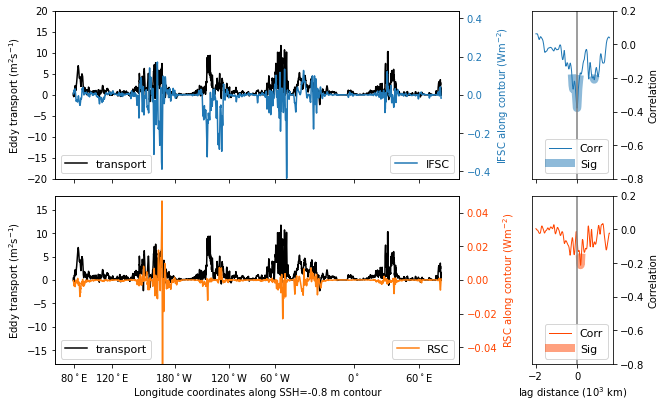

In [14]:
j_contour = 'H'
N=10
if contour_dict[j_contour]['shifted']==True:
    suffix = '_shiftedback'
else:
    suffix = ''
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
#top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
#bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
#vh_eddy_masked= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
# mask out water that touches surface or bottom on average
SSH = contour_dict[j_contour]['SSH']
# if SSH > -0.45:
#     print('SSH too big!!')
# rhoslice = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])
rhoslice = slice(1032.53,1033)
eddy_notcumsum = (vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins').fillna(0)
segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'_10yr_updatedMP.nc').Form_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)
distance = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
distance_small = distance[0:len(corr)]
distance_combined = np.append(-np.flip(distance_small)[:-1],distance_small)

f, ((ax, ax_inset), (axR,ax_insetR)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize = (10,6.5), sharex = 'col')
ax.plot(distance,y, color = 'k', label = 'transport')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('IFSC along contour (Wm$^{-2}$)', color='C0')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='C0')
ax2.plot(distance,EKE, color = 'C0', label = 'IFSC')

ax_inset.plot(distance_combined[1200:1800],corr_combined_E[1200:1800],'C0',linewidth=1,label='Corr')
ax_inset.plot(distance_combined[1200:1800],(corr_combined_E*sig_combined_E)[1200:1800], color='C0',linewidth=8,alpha=0.5,label="Sig")
ax_inset.vlines(0,-0.8,0.2, color = 'grey')
ax.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)

ax_inset.legend(loc = 'lower right', fontsize = 11)
ax.set_xlabel('')
ax_inset.set_xlabel('')
ax.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_inset.yaxis.tick_right()
ax_inset.yaxis.set_label_position("right")
ax_inset.set_ylabel('Correlation')

# ax_inset2 = plt.axes([0.17,0.77,0.2,0.1])
# ax_inset_otherside = ax_inset2.twinx()
# ax_inset_otherside.tick_params(axis='y', labelcolor='C0')
# ax_inset_otherside.plot(distance[4800:5000],EKE[4800:5000], color = 'C0')
# ax_inset2.plot(distance[4800:5000],y[4800:5000], color = 'k')
# ax_inset2.set_xlabel('distance (10$^3$ km)', fontsize = 10)
# ax_inset2.tick_params(axis='x', labelsize= 10)
# ax_inset2.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.tick_params(axis='y', labelsize= 10)

# ax_inset_otherside.set_ylim(-0.1,0.4)
# ax_inset2.set_ylim(-4,16)

ax2.set_ylim(-0.44,0.44)
ax.set_ylim(-20,20)
#same for Reynolds
EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
N=10
EKE = uniform_filter1d(EKE, size=N)/segment_length
z_scaled = y.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(y)
EKE_scaled = EKE.where(y!=np.inf).where(y!=-np.inf).fillna(0)/np.max(EKE)
c_cor = Compute_Correlation(z_scaled,EKE_scaled)
c_cor2 = Compute_Correlation(EKE_scaled,z_scaled)
corr,sig,t,N = c_cor.cor_series()
corr2,sig2,t2,N2 = c_cor2.cor_series()
corr_combined_E = np.append(np.flip(corr2[1:]),corr)
sig_combined_E = np.append(np.flip(sig2)[1:],sig)

axR.plot(distance,y, color = 'k', label = 'transport')
ax2 = axR.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('RSC along contour (Wm$^{-2}$)', color='orangered')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='orangered')
ax2.plot(distance,EKE, color = 'C1', label = 'RSC')

ax_insetR.plot(distance_combined[1200:1800],corr_combined_E[1200:1800],'orangered',linewidth=1,label='Corr')
ax_insetR.plot(distance_combined[1200:1800],(corr_combined_E*sig_combined_E)[1200:1800], color='orangered',linewidth=8,alpha=0.5,label="Sig")
ax_insetR.vlines(0,-0.8,0.2, color = 'grey')
axR.legend(loc = 'lower left', fontsize = 11)
ax2.legend(loc = 'lower right', fontsize = 11)

ax_insetR.legend(loc = 'lower right', fontsize = 11)
ax_insetR.set_xlabel('lag distance (10$^3$ km)')
axR.set_ylabel('Eddy transport (m$^2$s$^{-1}$)')
ax_insetR.yaxis.tick_right()
ax_insetR.yaxis.set_label_position("right")
ax_insetR.set_ylabel('Correlation')
ax_insetR.set_ylim(-0.8,0.2)
ax_inset.set_ylim(-0.8,0.2)


# ax_inset2 = plt.axes([0.3,0.405,0.2,0.075])
# ax_inset_otherside = ax_inset2.twinx()
# ax_inset_otherside.tick_params(axis='y', labelcolor='orangered')
# ax_inset_otherside.plot(distance[4800:5000],EKE[4800:5000], color = 'C1')
# ax_inset2.plot(distance[4800:5000],y[4800:5000], color = 'k')
# ax_inset2.set_xlabel('distance (10$^3$ km)', fontsize = 10)
# ax_inset2.tick_params(axis='x', labelsize= 10)
# ax_inset2.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.tick_params(axis='y', labelsize= 10)
# ax_inset_otherside.set_ylim(-0.025,0.05)
# ax_inset2.set_ylim(-8,16)

ax2.set_ylim(-0.05,0.05)
axR.set_ylim(-18,18)

save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour


# run above distance indices code
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

ax.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
ax.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
axR.set_xlabel('Longitude coordinates along SSH='+str(SSH)+' m contour')


plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
plt.show()
f.subplots_adjust(bottom =0.15)

#ax_inset.set_xlim(-0.5,0.5)
#ax_insetR.set_xlim(-0.5,0.5)


#f.savefig('FSRScorr_SSH1.2.png',dpi = 400)

# cumulative integrals

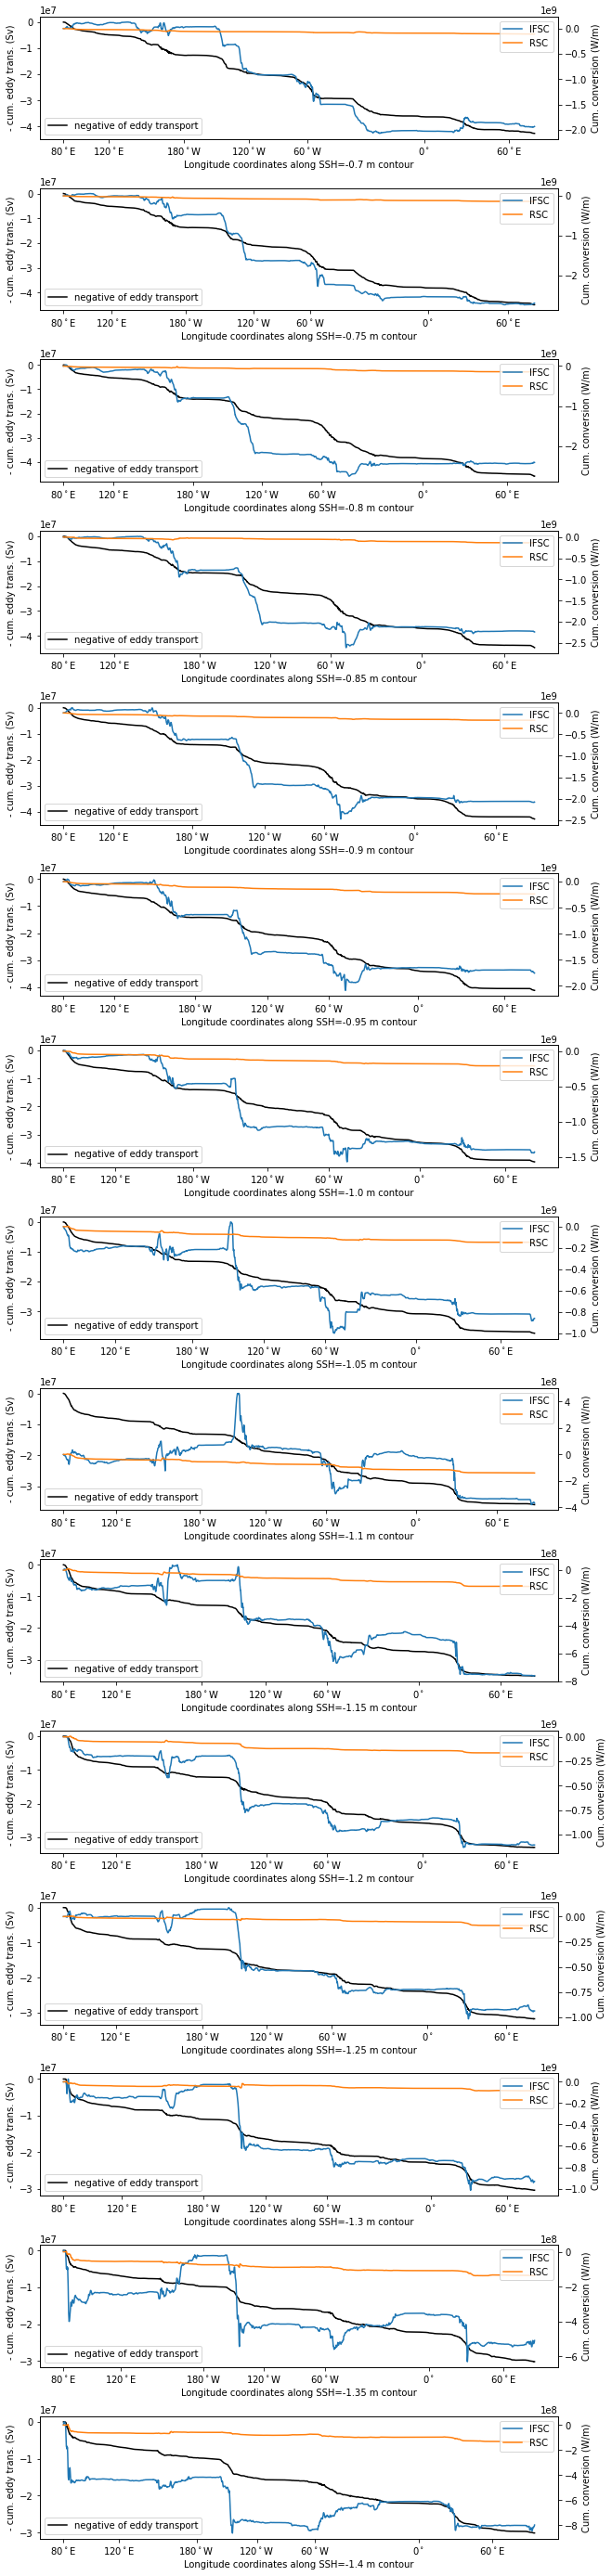

In [16]:
fig,axes = plt.subplots(nrows = 15,figsize = (10,50))

for i in np.arange(15):
    j_contour = ['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'][i+12]
    rhoslice = slice(1032.53,1033)
    ax = axes[i]
    N=10
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    SSH = contour_dict[j_contour]['SSH']
    vh_eddy = (-vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins').fillna(0)

    Form_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'_10yr_updatedMP.nc').Form_contour
    Form = Form_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').EKE_contour
    EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    Reynolds_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
    Reynolds = Reynolds_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length

    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

    distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour


    # run above distance indices code
    distance_indices = np.zeros(8)
    for i in np.arange(100,len(lon_along_contour.values)):
        if (distance_indices[1]==0):
            if (lon_along_contour.values[i]>-240):
                distance_indices[1] = lon_along_contour.contour_index.values[i]
        if (distance_indices[2]==0):
            if (lon_along_contour.values[i]>-180):
                distance_indices[2] = lon_along_contour.contour_index.values[i]
        if (distance_indices[3]==0):
            if (lon_along_contour.values[i]>-120):
                distance_indices[3] = lon_along_contour.contour_index.values[i]
        if (distance_indices[4]==0):
            if lon_along_contour.values[i]>-60:
                distance_indices[4] = lon_along_contour.contour_index.values[i]
        if (distance_indices[5]==0):
            if (lon_along_contour.values[i]>0):
                distance_indices[5] = lon_along_contour.contour_index.values[i]
        if (distance_indices[6]==0):
            if (lon_along_contour.values[i]>60):
                distance_indices[6] = lon_along_contour.contour_index.values[i]
    distance_indices[7] = len(lon_along_contour.contour_index.values)-1

    ax.plot(distance.values,vh_eddy.cumsum('contour_index').values, color = 'k', label = 'negative of eddy transport')
    ax.set_ylabel('- cum. eddy trans. (Sv)')
    ax2 = ax.twinx()
    ax2.plot(distance.values,(Form*segment_length).cumsum('contour_index').values,color = 'C0', label = 'IFSC')
    ax2.plot(distance.values,(Reynolds*segment_length).cumsum('contour_index').values,color = 'C1', label = 'RSC')
    ax2.set_ylabel('Cum. conversion (W/m)')

    ax.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
    ax.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
    ax.set_xlabel('Longitude coordinates along SSH='+str(SSH)+' m contour')

    ax.legend(loc = 'lower left')
    ax2.legend(loc = 'upper right')
    
fig.subplots_adjust(hspace =0.4)

## what about just the top part of the bottom water? Where adiabatic assumption more likely to hold?

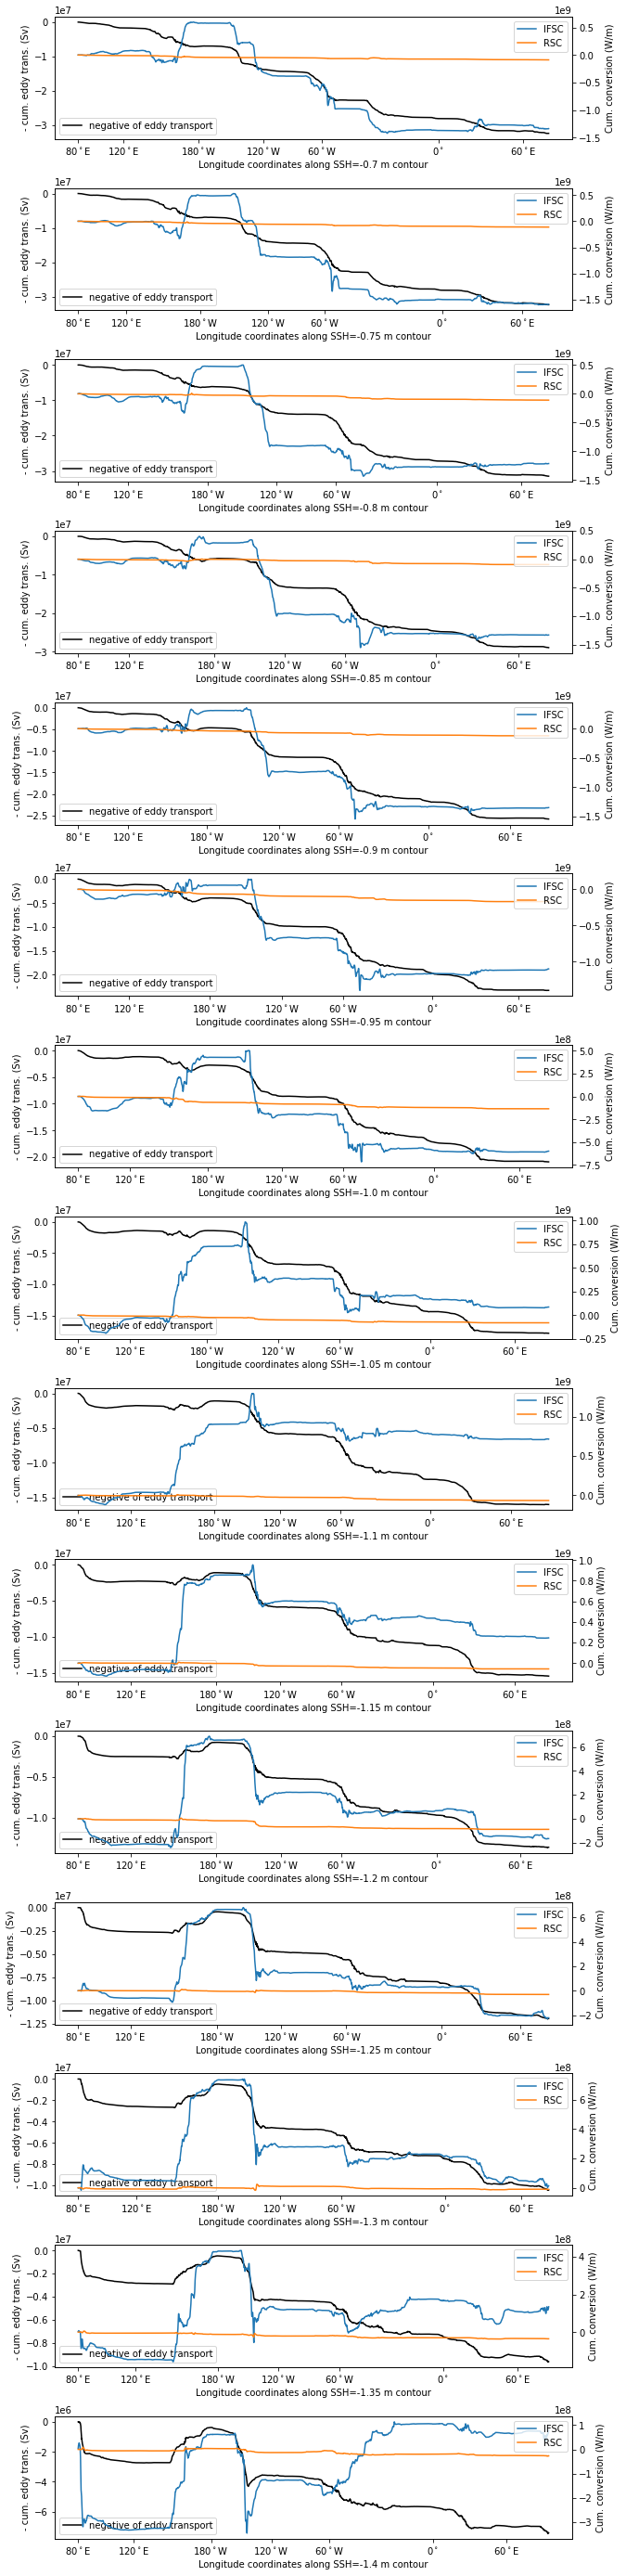

In [17]:
# only top part of bottom water
fig,axes = plt.subplots(nrows = 15,figsize = (10,50))

for i in np.arange(15):
    j_contour = ['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'][i+12]
    rhoslice = slice(1032.53,1032.55)
    ax = axes[i]
    N=10
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    SSH = contour_dict[j_contour]['SSH']
    vh_eddy = (-vh_eddy).sel(isopycnal_bins=rhoslice).sum('isopycnal_bins').fillna(0)

    Form_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'_10yr_updatedMP.nc').Form_contour
    Form = Form_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').EKE_contour
    EKE = EKE_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    Reynolds_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
    Reynolds = Reynolds_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length

    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

    distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour


    # run above distance indices code
    distance_indices = np.zeros(8)
    for i in np.arange(100,len(lon_along_contour.values)):
        if (distance_indices[1]==0):
            if (lon_along_contour.values[i]>-240):
                distance_indices[1] = lon_along_contour.contour_index.values[i]
        if (distance_indices[2]==0):
            if (lon_along_contour.values[i]>-180):
                distance_indices[2] = lon_along_contour.contour_index.values[i]
        if (distance_indices[3]==0):
            if (lon_along_contour.values[i]>-120):
                distance_indices[3] = lon_along_contour.contour_index.values[i]
        if (distance_indices[4]==0):
            if lon_along_contour.values[i]>-60:
                distance_indices[4] = lon_along_contour.contour_index.values[i]
        if (distance_indices[5]==0):
            if (lon_along_contour.values[i]>0):
                distance_indices[5] = lon_along_contour.contour_index.values[i]
        if (distance_indices[6]==0):
            if (lon_along_contour.values[i]>60):
                distance_indices[6] = lon_along_contour.contour_index.values[i]
    distance_indices[7] = len(lon_along_contour.contour_index.values)-1

    ax.plot(distance.values,vh_eddy.cumsum('contour_index').values, color = 'k', label = 'negative of eddy transport')
    ax.set_ylabel('- cum. eddy trans. (Sv)')
    ax2 = ax.twinx()
    ax2.plot(distance.values,(Form*segment_length).cumsum('contour_index').values,color = 'C0', label = 'IFSC')
    ax2.plot(distance.values,(Reynolds*segment_length).cumsum('contour_index').values,color = 'C1', label = 'RSC')
    ax2.set_ylabel('Cum. conversion (W/m)')

    ax.set_xticks(distance.values[distance_indices.astype(int)[:-1]])
    ax.set_xticklabels(['80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E']);
    ax.set_xlabel('Longitude coordinates along SSH='+str(SSH)+' m contour')

    ax.legend(loc = 'lower left')
    ax2.legend(loc = 'upper right')
    
fig.subplots_adjust(hspace =0.4)

# maps of energy terms in bottom layer

In [18]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'

EKE = xr.open_dataset(save_dir+'EKE_10yr.nc').EKE
Reynolds = xr.open_dataset(save_dir+'Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset(save_dir+'Form_stress_10yr_updatedMP.nc').Form_stress

FS_bottom = Form_stress.sel(isopycnal_bins = slice(1032.53,1050)).sum('isopycnal_bins')
EKE_bottom = EKE.sel(isopycnal_bins = slice(1032.53,1050)).sum('isopycnal_bins')
RS_bottom = Reynolds.sel(isopycnal_bins = slice(1032.53,1050)).sum('isopycnal_bins')


In [19]:
ht = cc.querying.getvar(expt,'ht', session,n=1)
ht = ht.sel(yt_ocean = slice(-90,-34.99))
mask = (ht*0+1).fillna(0)


Text(0.5, 0.98, '$\\sigma_1>1032.53$ integrated energy terms')

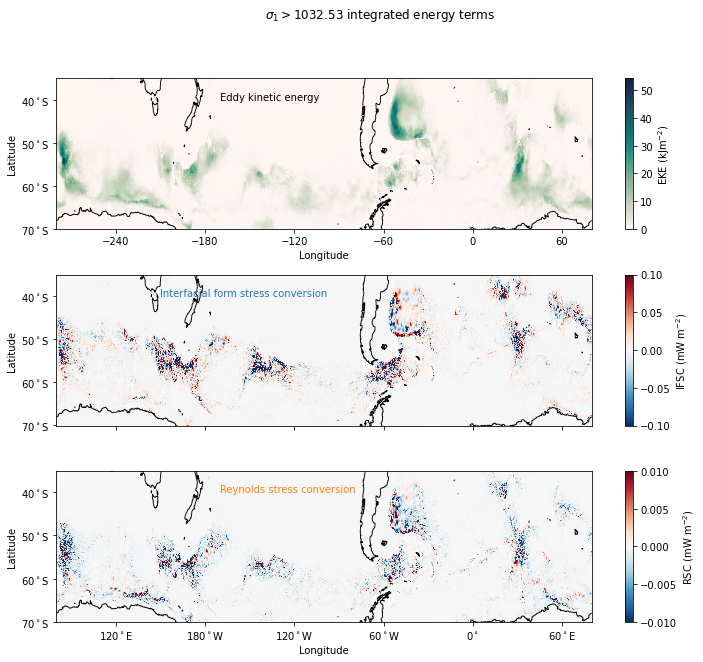

In [20]:
fig = plt.figure(figsize = (12,10))
gs = gridspec.GridSpec(3,1) 
ax0, ax1, ax2,  = plt.subplot(gs[0,0]), plt.subplot(gs[1,0]), plt.subplot(gs[2,0])
gs.update(hspace = 0.3)
p1 = (EKE_bottom/1000).plot(ax = ax0, cmap = cm.cm.tempo, add_colorbar = False)
plt.colorbar(p1, ax = ax0,label = 'EKE (kJm$^{-2}$)')
p2 = (FS_bottom).plot(ax = ax1, cmap = 'RdBu_r', vmin = -0.1, vmax = 0.1, add_colorbar = False)
plt.colorbar(p2, ax = ax1,label = 'IFSC (mW m$^{-2}$)')
p3 = (RS_bottom).plot(ax = ax2, cmap = 'RdBu_r', vmin = -0.01, vmax = 0.01, add_colorbar = False)
plt.colorbar(p3, ax = ax2,label = 'RSC (mW m$^{-2}$)')

mask.plot.contour(ax = ax0,levels = [0.5],colors = 'k', linewidths = 0.9)
mask.plot.contour(ax = ax1,levels = [0.5],colors = 'k', linewidths = 0.9)
mask.plot.contour(ax = ax2,levels = [0.5],colors = 'k', linewidths = 0.9)

ax0.set_xticks(np.arange(-240,100,60))
ax1.set_xticks(np.arange(-240,100,60))

#plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax0.set_ylabel('Latitude')
ax1.set_ylabel('Latitude')
ax2.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax1.set_xlabel('')
ax2.set_xlabel('Longitude')
# ax0.set_title('Surface')
# ax1.set_title('Upwelling Arm')
# ax2.set_title('Bottom')
ax2.set_xticks(np.arange(-240,100,60))
ax2.set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'))
ax0.set_yticks(np.arange(-70,-39,10))
ax0.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])
ax1.set_yticks(np.arange(-70,-39,10))
ax1.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])
ax2.set_yticks(np.arange(-70,-39,10))
ax2.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])

# scfac = 11
# ax3.plot((EKExy/hxy).sel(isopycnal_bins = slice(1025,1035))/1e15,(EKExy.sel(isopycnal_bins = slice(1025,1035)).isopycnal_bins.values-1024)**scfac, color = 'C2')

# ax3.hlines((EKExy.sel(isopycnal_bins = slice(1025,1035)).isopycnal_bins.values-1024)**scfac,0,2.5, color = 'grey', linewidth = 0.5)
# rhos = np.array([1030,1031,1031.5,1032,1032.2,1032.4,1032.5,1032.6])
# ax3.set_yticks((rhos-1024)**scfac)
# ax3.set_yticklabels(rhos, fontsize = 12)

# ax3.set_ylim(8.65**scfac,5**scfac)
# ax3.set_ylabel('Potential density ($\sigma_1$) (kgm$^{-3}$)')
# ax3.set_xlabel('EKE/h (PJ/m)')
# ax3.vlines(0.5,8.525**scfac,8.423**scfac, color = 'k', linewidth = 3)
# ax3.text(0.8,8.47**scfac, 'Upwelling \n Everywhere')
# ax3.text(0.8,8.3**scfac, 'Top')
# ax3.text(0.8,8.6**scfac, 'Bottom')

ax0.text(-170,-40,'Eddy kinetic energy')
ax1.text(-210,-40,'Interfacial form stress conversion', color = 'C0')
ax2.text(-170,-40,'Reynolds stress conversion', color = 'C1')

fig.suptitle(r'$\sigma_1>1032.53$ integrated energy terms')
#fig.savefig('temp.png',dpi = 400)

In [21]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'

EKE = xr.open_dataset(save_dir+'EKE_10yr.nc').EKE
Reynolds = xr.open_dataset(save_dir+'Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset(save_dir+'Form_stress_10yr_updatedMP.nc').Form_stress

FS_bottom = Form_stress.sel(isopycnal_bins = slice(1032.53,1052.55)).sum('isopycnal_bins')
EKE_bottom = EKE.sel(isopycnal_bins = slice(1032.53,1052.55)).sum('isopycnal_bins')
RS_bottom = Reynolds.sel(isopycnal_bins = slice(1032.53,1052.55)).sum('isopycnal_bins')


Text(0.5, 0.98, '1032.55>$\\sigma_1>1032.53$ integrated energy terms')

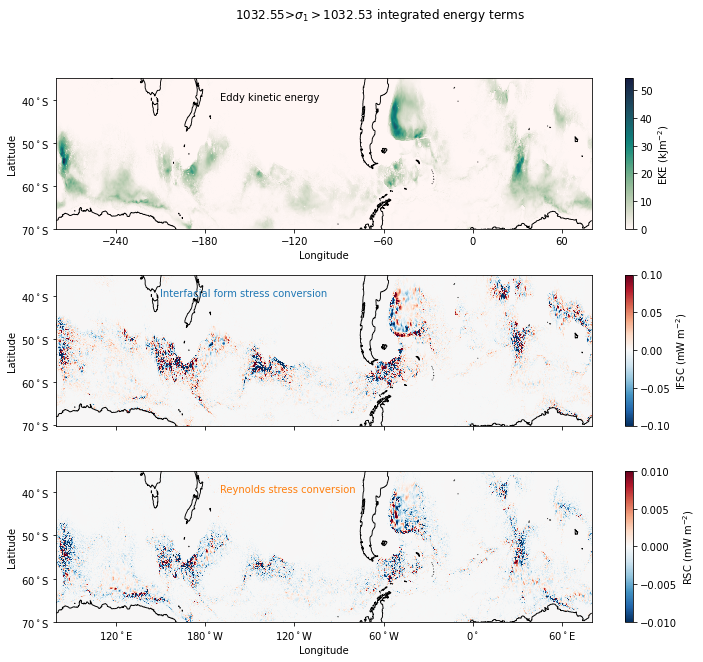

In [22]:
fig = plt.figure(figsize = (12,10))
gs = gridspec.GridSpec(3,1) 
ax0, ax1, ax2,  = plt.subplot(gs[0,0]), plt.subplot(gs[1,0]), plt.subplot(gs[2,0])
gs.update(hspace = 0.3)
p1 = (EKE_bottom/1000).plot(ax = ax0, cmap = cm.cm.tempo, add_colorbar = False)
plt.colorbar(p1, ax = ax0,label = 'EKE (kJm$^{-2}$)')
p2 = (FS_bottom).plot(ax = ax1, cmap = 'RdBu_r', vmin = -0.1, vmax = 0.1, add_colorbar = False)
plt.colorbar(p2, ax = ax1,label = 'IFSC (mW m$^{-2}$)')
p3 = (RS_bottom).plot(ax = ax2, cmap = 'RdBu_r', vmin = -0.01, vmax = 0.01, add_colorbar = False)
plt.colorbar(p3, ax = ax2,label = 'RSC (mW m$^{-2}$)')

mask.plot.contour(ax = ax0,levels = [0.5],colors = 'k', linewidths = 0.9)
mask.plot.contour(ax = ax1,levels = [0.5],colors = 'k', linewidths = 0.9)
mask.plot.contour(ax = ax2,levels = [0.5],colors = 'k', linewidths = 0.9)

ax0.set_xticks(np.arange(-240,100,60))
ax1.set_xticks(np.arange(-240,100,60))

#plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax0.set_ylabel('Latitude')
ax1.set_ylabel('Latitude')
ax2.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax1.set_xlabel('')
ax2.set_xlabel('Longitude')
# ax0.set_title('Surface')
# ax1.set_title('Upwelling Arm')
# ax2.set_title('Bottom')
ax2.set_xticks(np.arange(-240,100,60))
ax2.set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'))
ax0.set_yticks(np.arange(-70,-39,10))
ax0.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])
ax1.set_yticks(np.arange(-70,-39,10))
ax1.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])
ax2.set_yticks(np.arange(-70,-39,10))
ax2.set_yticklabels(['70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S'])

# scfac = 11
# ax3.plot((EKExy/hxy).sel(isopycnal_bins = slice(1025,1035))/1e15,(EKExy.sel(isopycnal_bins = slice(1025,1035)).isopycnal_bins.values-1024)**scfac, color = 'C2')

# ax3.hlines((EKExy.sel(isopycnal_bins = slice(1025,1035)).isopycnal_bins.values-1024)**scfac,0,2.5, color = 'grey', linewidth = 0.5)
# rhos = np.array([1030,1031,1031.5,1032,1032.2,1032.4,1032.5,1032.6])
# ax3.set_yticks((rhos-1024)**scfac)
# ax3.set_yticklabels(rhos, fontsize = 12)

# ax3.set_ylim(8.65**scfac,5**scfac)
# ax3.set_ylabel('Potential density ($\sigma_1$) (kgm$^{-3}$)')
# ax3.set_xlabel('EKE/h (PJ/m)')
# ax3.vlines(0.5,8.525**scfac,8.423**scfac, color = 'k', linewidth = 3)
# ax3.text(0.8,8.47**scfac, 'Upwelling \n Everywhere')
# ax3.text(0.8,8.3**scfac, 'Top')
# ax3.text(0.8,8.6**scfac, 'Bottom')

ax0.text(-170,-40,'Eddy kinetic energy')
ax1.text(-210,-40,'Interfacial form stress conversion', color = 'C0')
ax2.text(-170,-40,'Reynolds stress conversion', color = 'C1')

fig.suptitle(r'1032.55>$\sigma_1>1032.53$ integrated energy terms')
#fig.savefig('temp.png',dpi = 400)